In [15]:
import pandas as pd
import numpy as np


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score


import matplotlib.pyplot as plt


In [16]:
# Reading the training and testing dataset
df_data = pd.read_csv('./data/train_clean.csv')

#convert abstract column to str
df_data['abstract'] = df_data['abstract'].astype(str)

df_data.head()




,id,abstract,category,category_num
0,271675,bacteria often expos multipl stimuli complex e...,q-bio-QM,138
1,412276,accur knowledg thermodynam properti zero tempe...,hep-ph-,68
2,256956,largest x solar flare solar cycl preced x flar...,astro-ph-SR,7
3,427612,say random integ variabl x monoton modulu char...,math-PR,93
4,113852,deriv formula express joint distribut cyclic v...,math-CO,76


In [3]:
# #create subset of train data from category_num 0-10 only from train 

# df_data_subset = df_data[df_data['category_num']<=10]


# #save to csv
# df_data_subset.to_csv('./test/train_clean_subset.csv',index=False)

# df_data_subset.head()

In [20]:
#create validation subset .csv from validation_clean.csv
# df_validation_clean = pd.read_csv('./data/validation_clean.csv')

# df_validation_clean['abstract'] = df_validation_clean['abstract'].astype(str)

# #subset data from category_num 0-10 only ,from validation
# df_validation_clean_subset = df_validation_clean[df_validation_clean['category_num']<=10]

# df_validation_clean_subset.category_num.value_counts()

# # save to csv
# # df_validation_clean_subset.to_csv('./test/validation_subset.csv',index=False)

# df_validation_clean_subset.head()

# #remove category and category_num from validation.csv
# df_validation_clean_subset.drop(['category','category_num'],axis=1,inplace=True)
# df_validation_clean_subset.head()

# save df to csv te be used as test data
# df_validation_clean_subset.to_csv('./test/test_validation_subset.csv',index=False)
# df_validation_clean_subset.head()


NameError: name 'df_validation_clean_subset' is not defined

In [17]:
#pandas
# # The maximum number of words to be used. (most frequent)
MAX_NB_WORDS =50000
# Max number of words in each abstract
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 100

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,oov_token = '<UNK>') 
tokenizer.fit_on_texts(df_data.abstract) # fit the tokenizer on the abstracts
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 170644 unique tokens.


In [18]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df_data.abstract)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (390603, 300)


In [7]:
# df_wordindex = pd.DataFrame.from_dict(word_index, orient='index')

# #save to csv
# df_wordindex.to_csv('testword_index.csv')

# df_wordindex.head(100)

In [8]:
#pandas

Y = pd.get_dummies(df_data['category']).values
print('Shape of label tensor:', Y.shape)


Shape of label tensor: (49316, 11)


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(44384, 300) (44384, 11)
(4932, 300) (4932, 11)


In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [10]:


model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(Y[1]), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
epochs = 10
batch_size= 128

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 11)                1111      
Total params: 5,081,511
Trainable params: 5,081,511
Non-trainable params: 0
_________________________________________________________________


In [11]:
# train the model  on the whole training set with early stopping 
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]) 

Epoch 1/10
313/313 [==============================] - 698s 2s/step - loss: 1.3483 - accuracy: 0.4899 - val_loss: 0.7598 - val_accuracy: 0.7439
Epoch 2/10
313/313 [==============================] - 700s 2s/step - loss: 0.6244 - accuracy: 0.7877 - val_loss: 0.5921 - val_accuracy: 0.7932
Epoch 3/10
313/313 [==============================] - 721s 2s/step - loss: 0.5061 - accuracy: 0.8325 - val_loss: 0.6259 - val_accuracy: 0.7853
Epoch 4/10
313/313 [==============================] - 647s 2s/step - loss: 0.4310 - accuracy: 0.8570 - val_loss: 0.5234 - val_accuracy: 0.8193
Epoch 5/10
313/313 [==============================] - 640s 2s/step - loss: 0.3734 - accuracy: 0.8747 - val_loss: 0.5090 - val_accuracy: 0.8243
Epoch 6/10
313/313 [==============================] - 641s 2s/step - loss: 0.3115 - accuracy: 0.8967 - val_loss: 0.4976 - val_accuracy: 0.8308
Epoch 7/10
313/313 [==============================] - 633s 2s/step - loss: 0.2817 - accuracy: 0.9067 - val_loss: 0.5278 - val_accuracy: 0.8304

In [20]:
# # save trained model to disk
# model.save('./Test_model/model1.h5')

# # # import load model module 

from keras.models import *
new_model = load_model('./Saved_model/model25.h5')

In [6]:
accr = new_model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

NameError: name 'X_test' is not defined

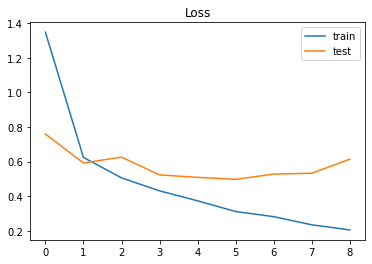

In [33]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

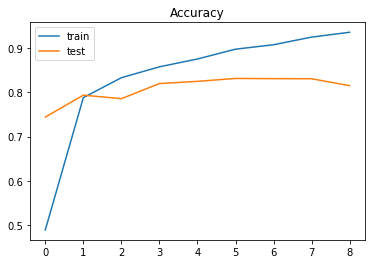

In [34]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [21]:



#pandas df from csv 
df_test=pd.read_csv('./data/test_clean.csv')
df_test.head()




,id,abstract
0,430065,depth map obtain commerci depth sensor alway l...
1,75226,lambda express introduc java program languag p...
2,301990,propos demonstr gamma gamma collid w gg gev ad...
3,301001,physic lab student experi wide rang equit ineq...
4,280179,exist local minima one hidden layer relu netwo...


In [22]:
column_names = ['id','category_num']

df_solution = pd.DataFrame(columns = column_names)
df_solution

,id,category_num


In [24]:
## copy 'id' column of test.csv to "Id" column of df_solution
df_solution.id=df_test.id   # or use below method
# df_solution["id"]=df_test["id"].values
df_solution.head()

,id,category_num
0,430065,NaN
1,75226,NaN
2,301990,NaN
3,301001,NaN
4,280179,NaN


In [25]:

def predict_category(text):
    new_abstract = [text]
    seq = tokenizer.texts_to_sequences(new_abstract)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = new_model.predict(padded)
    print(pred.argmax())
    return pred.argmax()


df_solution['category_num'] = df_test['abstract'].apply(predict_category)
    

25
50
108
118
40
23
16
9
70
51
55
4
54
16
75
153
25
51
25
153
92
39
40
40
92
95
137
4
40
25
31
2
51
46
119
100
29
150
40
92
69
73
25
37
65
90
79
4
9
76
92
6
79
7
4
14
7
23
24
51
9
91
151
65
2
62
13
25
40
62
68
63
3
4
14
65
123
9
55
68
128
93
128
93
110
25
72
7
76
76
79
69
40
54
71
5
73
9
76
9
153
69
16
40
41
137
85
25
40
109
15
121
72
119
125
150
24
10
70
26
73
69
40
70
131
81
150
93
79
76
90
73
93
46
61
92
150
24
31
23
153
51
109
15
61
100
90
23
119
12
25
81
150
28
76
65
54
39
40
90
99
13
25
81
10
72
25
25
92
41
113
10
26
125
40
107
46
153
72
128
153
76
80
150
91
68
23
40
99
135
3
72
14
85
116
96
124
78
25
6
92
116
72
92
90
81
25
150
85
40
4
95
125
40
92
10
92
69
100
61
150
15
53
4
123
114
154
81
153
125
68
80
65
68
40
25
93
14
72
150
5
61
5
25
63
72
72
70
73
138
9
61
23
13
75
2
13
101
29
113
23
150
36
92
101
88
69
107
76
40
107
23
51
28
70
99
150
137
5
9
25
93
90
126
92
93
74
63
23
65
7
65
125
69
65
76
79
4
92
14
88
40
2
72
31
51
98
54
13
76
40
68
126
69
61
4
70
63
25
70
60
39
106
90

In [26]:
df_solution.to_csv('solution.csv',index=False)
df_solution.head(20)

,id,category_num
0,430065,25
1,75226,50
2,301990,108
3,301001,118
4,280179,40
5,153671,23
6,100940,16
7,219132,9
8,172982,70
9,277702,51
